# Plot model fits for PEERS simulation analysis

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
from psifr import fr
from mindstorm import statplot
from cymr import cmr
from dcmr import framework
from dcmr import figures

res_dir = Path(os.environ['PEERS_RESULTS'])
fit_dir = Path(os.environ['PEERS_FITS']) / 'simple'
fig_dir = Path(os.environ['PEERS_FIGURES']) / "plots"
fig_dir.mkdir(exist_ok=True, parents=True)

data_file = res_dir / 'peers_data.csv'
patterns_file = res_dir / 'peers_patterns.hdf5'
figures.set_style()

## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
model_names = [
    'DCMR-Variable',
    'DCMR-NonInteg',
    'DCMR-NonInteg-Focused',
    'DCMR-Focused',
    'CMR-MP16-L',
]
models, temp = framework.get_sim_models('peers2', 'set2', included=model_names)
index = [model_names.index(t) for t in temp]
models = [models[i] for i in index]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)
data['item_index'] = fr.pool_index(data['item'], patterns['items'])

In [4]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [5]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.3494320779585509, 0.6179457692495821, 0.5097488287111857),
 (0.27424883716016524, 0.5352555384607786, 0.4809527643729599),
 (0.21624286340091695, 0.4448723771080803, 0.44657182426748937),
 (0.17051215858853222, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [6]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.6078198204764038, 0.8100431115060979, 0.6886397639333763),
 (0.5016677447743987, 0.7426793533080586, 0.6602162691374847),
 (0.4070747349353, 0.652426424100314, 0.636598258552902),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [7]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.8450211160547234, 0.9362872108083329, 0.8814962450073144),
 (0.7912737188119296, 0.9119907090651371, 0.870686908851388),
 (0.7354447959037446, 0.8755917381696569, 0.8665505572807145),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [8]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

In [9]:
drw = data.groupby('source').apply(
    fr.distance_rank_window_asym, 
    'item_index', 
    1 - rsm, 
)

In [10]:
sources = model_names + ['Data']
drw = drw.reindex(sources, axis='index', level=0)
drw

subject     n      asym
source                                    
DCMR-Variable 0         63  8604 -0.022012
              1         64  4835 -0.003076
              2         65  6665 -0.009229
              3         66  7536 -0.002469
              4         67  7822  0.003527
...                    ...   ...       ...
Data          121      240   115  0.015773
              122      241   125 -0.050803
              123      242    81  0.010172
              124      243   107 -0.025263
              125      244   136 -0.023246

[756 rows x 3 columns]

In [11]:
drw.loc['Data', 'asym'].mean()

np.float64(-0.00728196345437044)

In [12]:
pg.ttest(drw.loc['Data', 'asym'].to_numpy(), 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.100661,125,two-sided,0.03768,"[-0.01, -0.0]",0.187142,0.827,0.549583


## Analyze distance rank asymmetry

,n
count,126.000000
mean,119.309524
std,32.822057
min,44.000000
25%,101.000000
50%,118.500000
75%,138.750000
max,203.000000


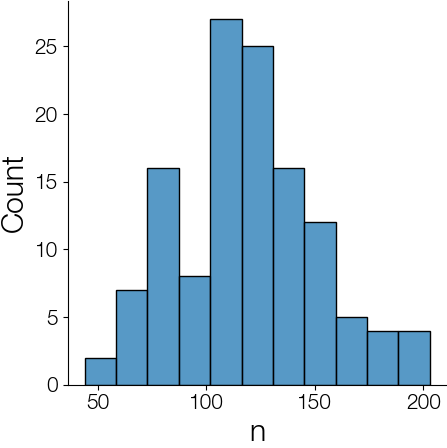

In [13]:
n = drw.loc['Data'].groupby('subject')[['n']].mean()
sns.displot(data=n, x='n')
n.describe()

In [14]:
drw.loc['Data'].groupby('subject')[['n']].sum().agg(['mean', 'sem'])

,n
mean,119.309524
sem,2.924021


In [15]:
diff = drw.copy()
diff['rank'] = diff['asym']

LINO NOT subset; don't know how to subset; dropped


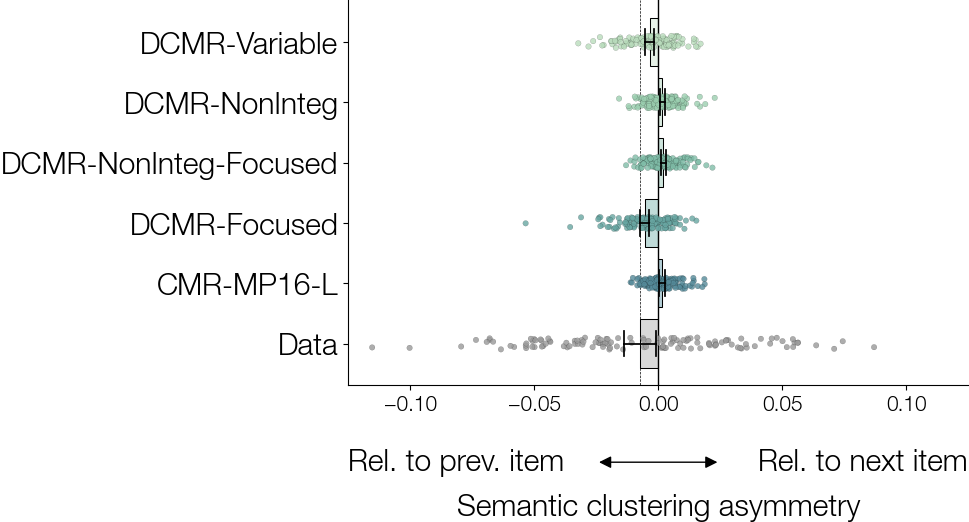

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
figures.plot_dist_rank_asym(diff, dark, light, ax=ax)
ax.set(xlim=(-0.125, 0.125))
None
fig.savefig(fig_dir / "dist_rank_asym.pdf")

In [17]:
p = diff['asym'].unstack('source')
pd.DataFrame({c: pg.ttest(p[c], 0).iloc[0] for c in p.columns})

,DCMR-Variable,DCMR-NonInteg,DCMR-NonInteg-Focused,DCMR-Focused,CMR-MP16-L,Data
T,-4.079757,2.950135,3.636447,-5.976498,2.821067,-2.100661
dof,125,125,125,125,125,125
alternative,two-sided,two-sided,two-sided,two-sided,two-sided,two-sided
p-val,0.00008,0.003793,0.000403,0.0,0.005569,0.03768
CI95%,"[-0.01, -0.0]","[0.0, 0.0]","[0.0, 0.0]","[-0.01, -0.0]","[0.0, 0.0]","[-0.01, -0.0]"
cohen-d,0.363454,0.262819,0.32396,0.532429,0.251321,0.187142
BF10,208.571,6.085,46.632,4.847e+05,4.322,0.827
power,0.981613,0.833337,0.950365,0.999964,0.799369,0.549583


In [18]:
test = pg.ttest(p['Data'], 0)
test

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.100661,125,two-sided,0.03768,"[-0.01, -0.0]",0.187142,0.827,0.549583


In [19]:
x = p['Data']
df = test['dof'].iloc[0]
m = float(np.mean(x))
sem = float(np.std(x) / np.sqrt(len(x) - 1))
lb = float(m + sem * stats.t.ppf(0.05 / 2, df))
ub = float(m + sem * stats.t.ppf(1 - 0.05 / 2, df))
print(f'{m=} {sem=} {lb=} {ub=}')

m=-0.00728196345437044 sem=0.0034665099923176937 lb=-0.01414261695564107 ub=-0.00042130995309981167


## Serial position effects

In [20]:
spc = data.groupby('source').apply(fr.spc)

LINO NOT subset; don't know how to subset; dropped


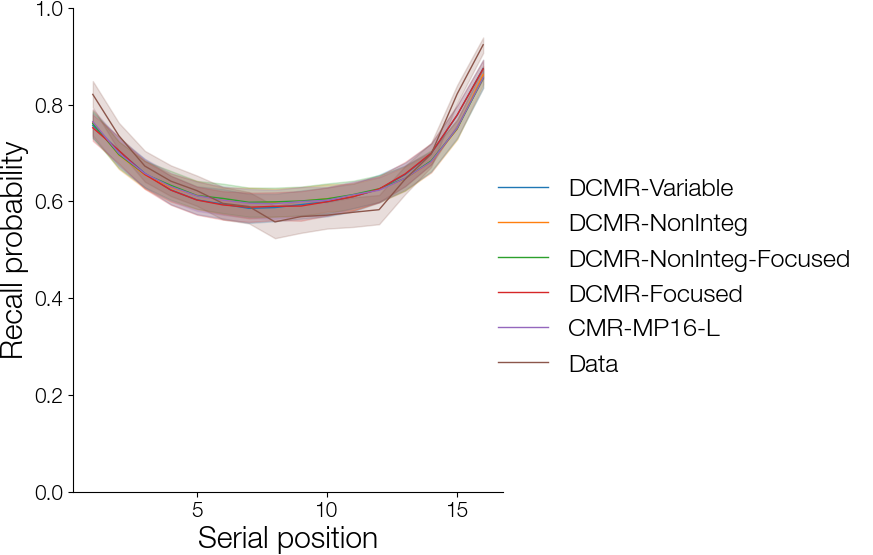

In [21]:
g = sns.relplot(
    spc,
    x='input',
    y='recall',
    hue='source',
    hue_order=sources,
    height=6,
    kind='line',
)
g.set(xlabel='Serial position', ylabel='Recall probability', ylim=(0, 1))
g.legend.set_title("")
g.savefig(fig_dir / 'spc_comp.pdf')

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


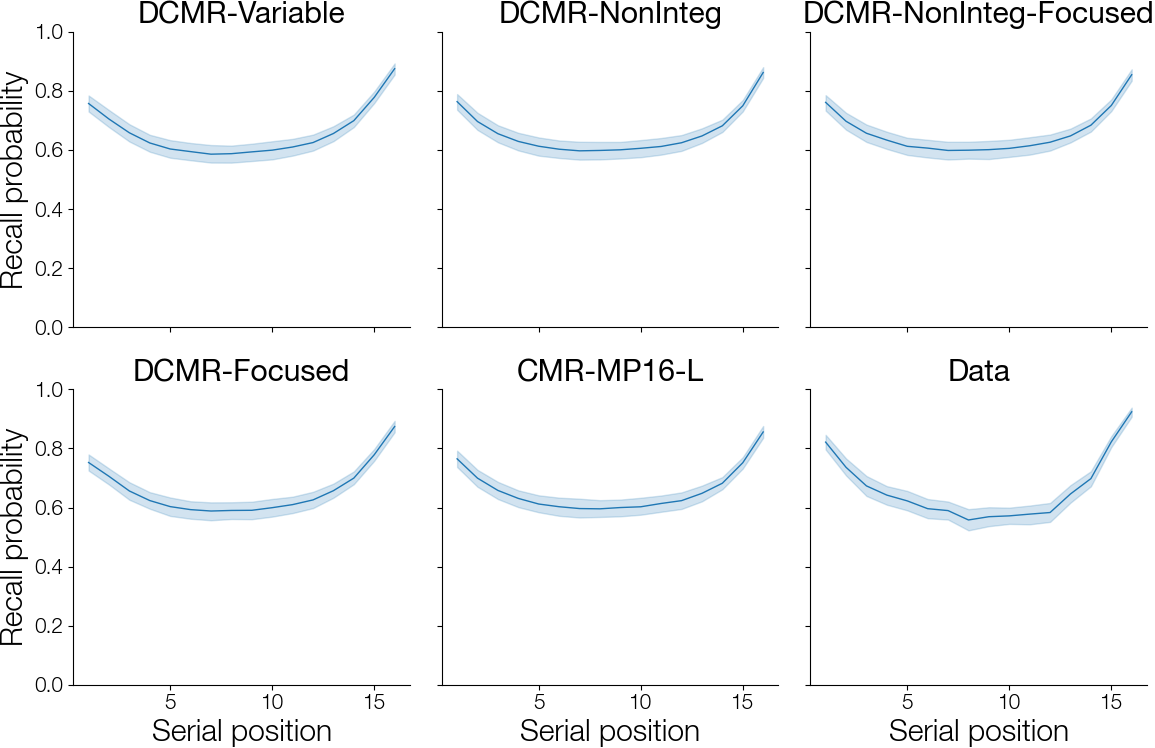

In [22]:
g = fr.plot_spc(
    spc, col='source', col_wrap=3, col_order=sources, height=4, aspect=1
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'spc.pdf');

In [23]:
pnr = data.groupby('source').apply(fr.pnr)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


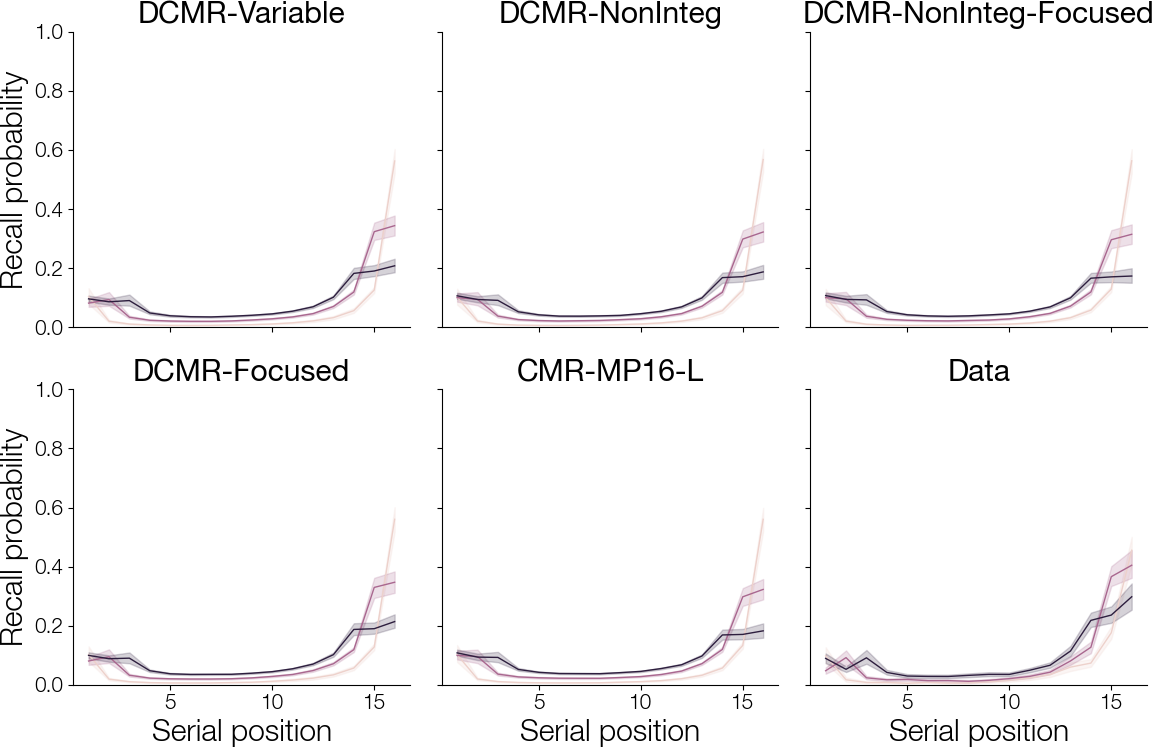

In [24]:
g = fr.plot_spc(
    pnr.query('output <= 3'), 
    hue='output', 
    col='source', 
    col_wrap=3, 
    col_order=sources,
    height=4, 
    aspect=1,
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'pnr.pdf');

In [25]:
lag_crp = data.groupby('source').apply(fr.lag_crp)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


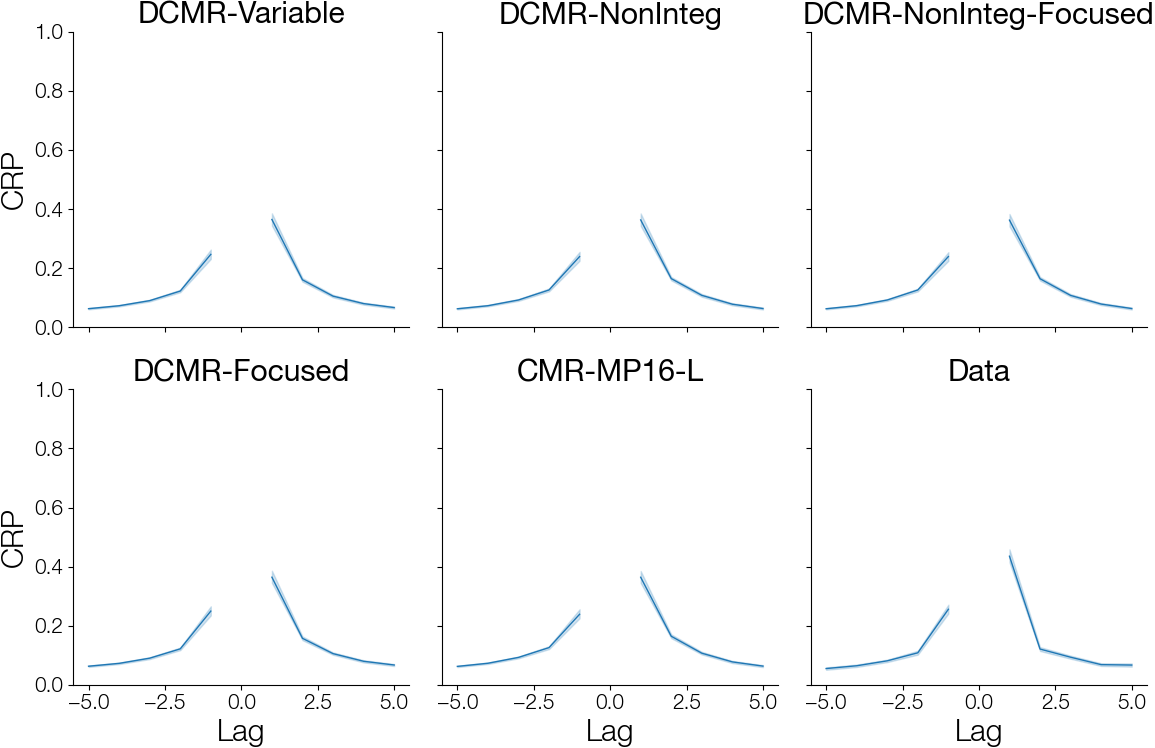

In [26]:
g = fr.plot_lag_crp(
    lag_crp, col='source', col_wrap=3, col_order=sources, height=4, aspect=1
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'crp.pdf')

## Clustering measures

In [27]:
lag_rank_within = data.groupby('source').apply(fr.lag_rank)

LINO NOT subset; don't know how to subset; dropped


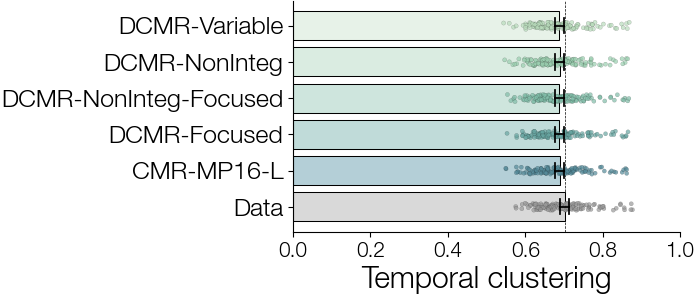

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    lag_rank_within.reindex(sources, axis='index', level=0),
    y='source',
    x='rank',
    hue='source',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [29]:
use_rank = data.groupby('source').apply(fr.distance_rank, 'item_index', 1 - rsm)

LINO NOT subset; don't know how to subset; dropped


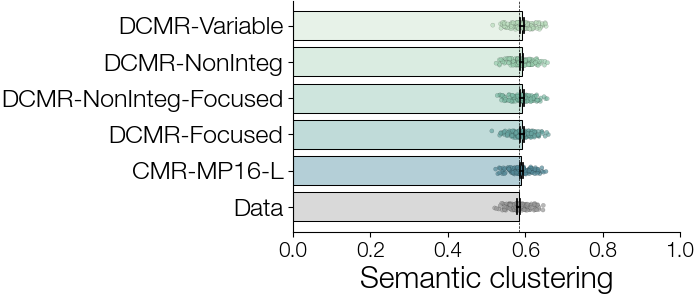

In [30]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    use_rank.reindex(sources, axis='index', level=0),
    y='source',
    x='rank',
    hue='source',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Clustering and distance rank asymmetry

In [31]:
comb = diff.reset_index(1, drop=True).set_index('subject', append=True)
temp = lag_rank_within.reset_index(1, drop=True).set_index('subject', append=True)
comb['temp'] = temp['rank']
comb['recall'] = data.groupby(['source', 'subject'])['recall'].mean()
comb = comb.drop(columns=['rank', 'n'])

In [63]:
temp = lag_crp.reset_index(1, drop=True).set_index('subject', append=True)
lag_n1 = temp.query('lag == -1')['prob']
lag_p1 = temp.query('lag == 1')['prob']
lag_asym = lag_p1 - lag_n1
comb['lag_asym'] = lag_asym

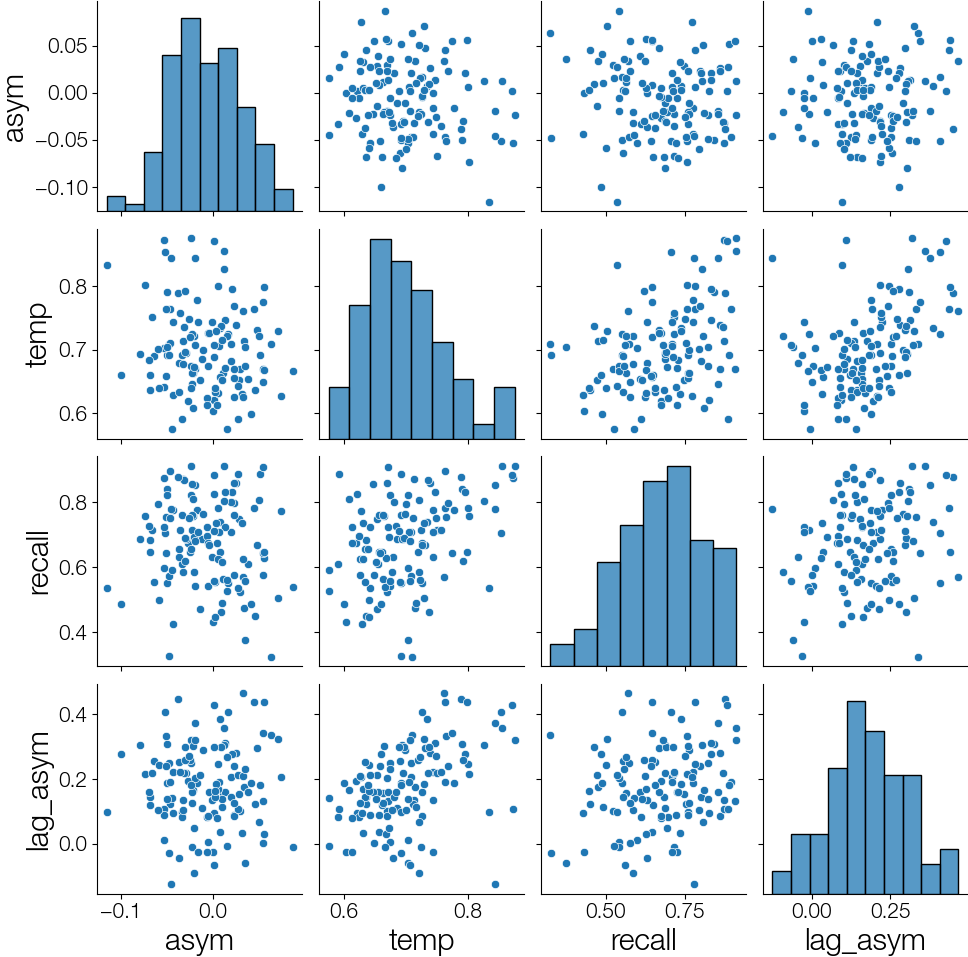

In [64]:
sns.pairplot(comb.loc['Data'])

In [65]:
pg.corr(comb.loc['Data', 'asym'], comb.loc['Data', 'recall'])

,n,r,CI95%,p-val,BF10,power
pearson,126,-0.091041,"[-0.26, 0.09]",0.310652,0.185,0.173907


In [66]:
pg.corr(comb.loc['Data', 'asym'], comb.loc['Data', 'temp'])

,n,r,CI95%,p-val,BF10,power
pearson,126,-0.142772,"[-0.31, 0.03]",0.110753,0.392,0.359455


In [67]:
pg.corr(comb.loc['Data', 'asym'], comb.loc['Data', 'lag_asym'])

,n,r,CI95%,p-val,BF10,power
pearson,126,0.033367,"[-0.14, 0.21]",0.7107,0.119,0.06582


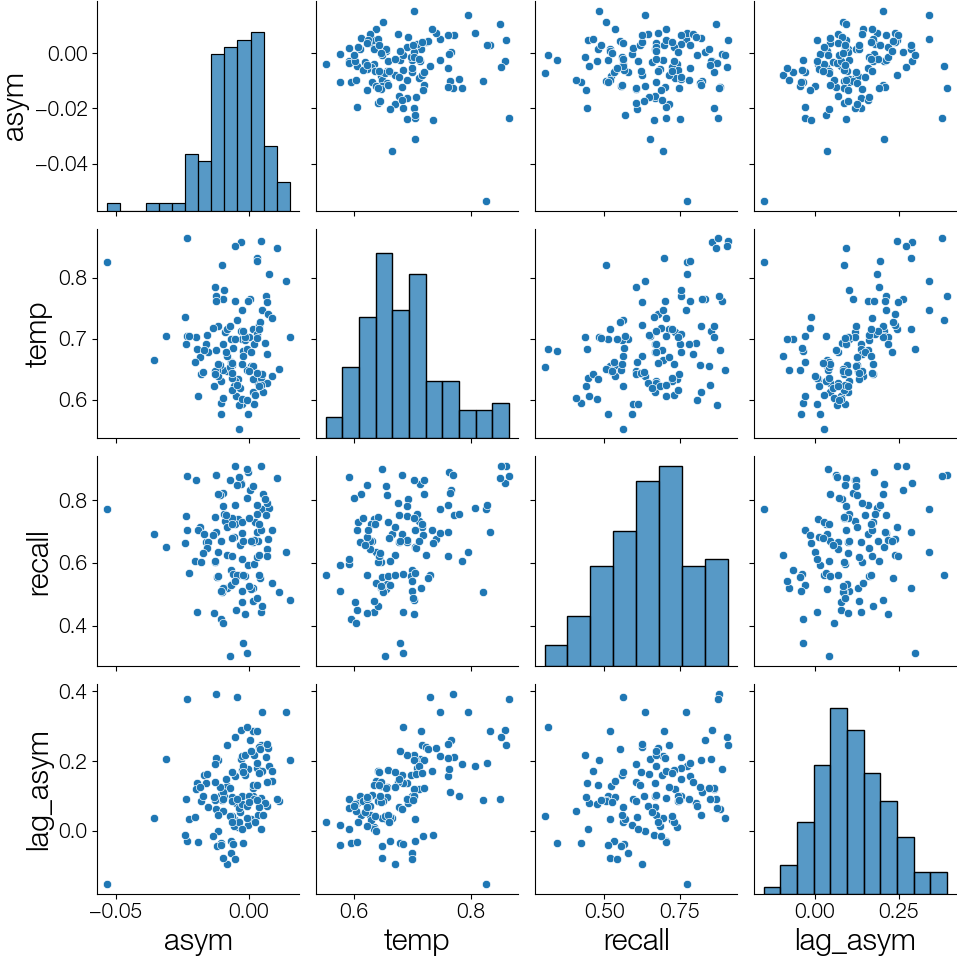

In [70]:
sns.pairplot(comb.loc['DCMR-Focused'])

In [72]:
pg.corr(comb.loc['DCMR-Focused', 'asym'], comb.loc['DCMR-Focused', 'recall'])

,n,r,CI95%,p-val,BF10,power
pearson,126,-0.056968,"[-0.23, 0.12]",0.526337,0.136,0.09713


In [73]:
pg.corr(comb.loc['DCMR-Focused', 'asym'], comb.loc['DCMR-Focused', 'temp'])

,n,r,CI95%,p-val,BF10,power
pearson,126,-0.02023,"[-0.19, 0.16]",0.822099,0.114,0.055699


In [74]:
pg.corr(comb.loc['DCMR-Focused', 'asym'], comb.loc['DCMR-Focused', 'lag_asym'])

,n,r,CI95%,p-val,BF10,power
pearson,126,0.310829,"[0.14, 0.46]",0.000396,54.985,0.947162


## Shifted distance rank

In [34]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
)

LINO NOT subset; don't know how to subset; dropped


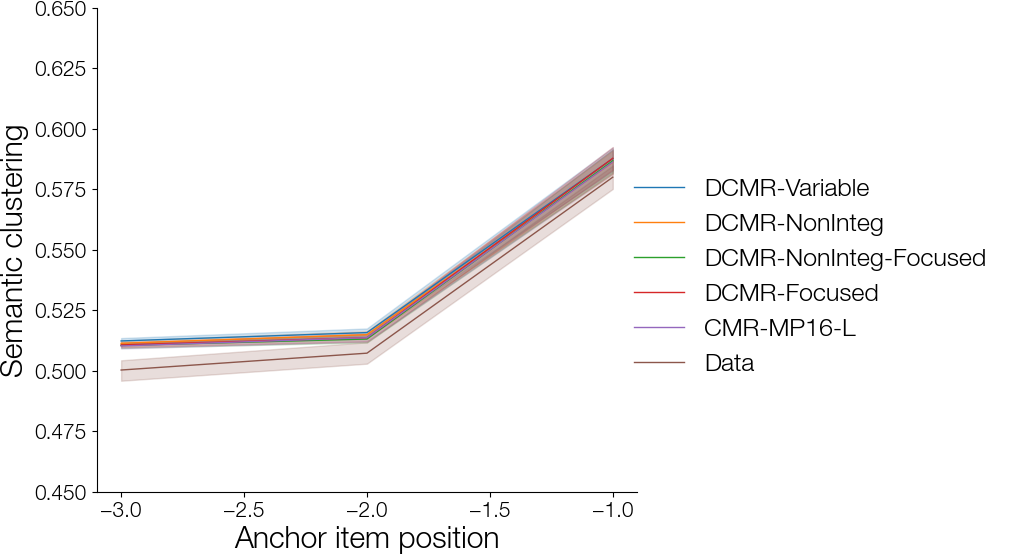

In [35]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    hue_order=sources,
    kind='line', 
    height=6,
    aspect=1.2,
)
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
g.legend.set_title("")
g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [36]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.225321,250,two-sided,0.026952,"[0.0, 0.01]",0.280364,1.421,0.601349


In [37]:
subs = dist_rank.loc['DCMR-Variable']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.174481,250,two-sided,0.001689,"[0.0, 0.01]",0.399947,15.31,0.885376


In [38]:
subs = dist_rank.loc['DCMR-Focused']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.160993,250,two-sided,0.001766,"[0.0, 0.0]",0.398248,14.72,0.882753


In [39]:
subs = dist_rank.loc['DCMR-NonInteg']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.808189,250,two-sided,0.000176,"[0.0, 0.01]",0.479787,115.695,0.96664


In [40]:
subs = dist_rank.loc['DCMR-NonInteg-Focused']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.818091,250,two-sided,0.005217,"[0.0, 0.0]",0.355046,5.712,0.801583


## Compound lag-CRP

In [41]:
crp = data.groupby('source').apply(fr.lag_crp_compound)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


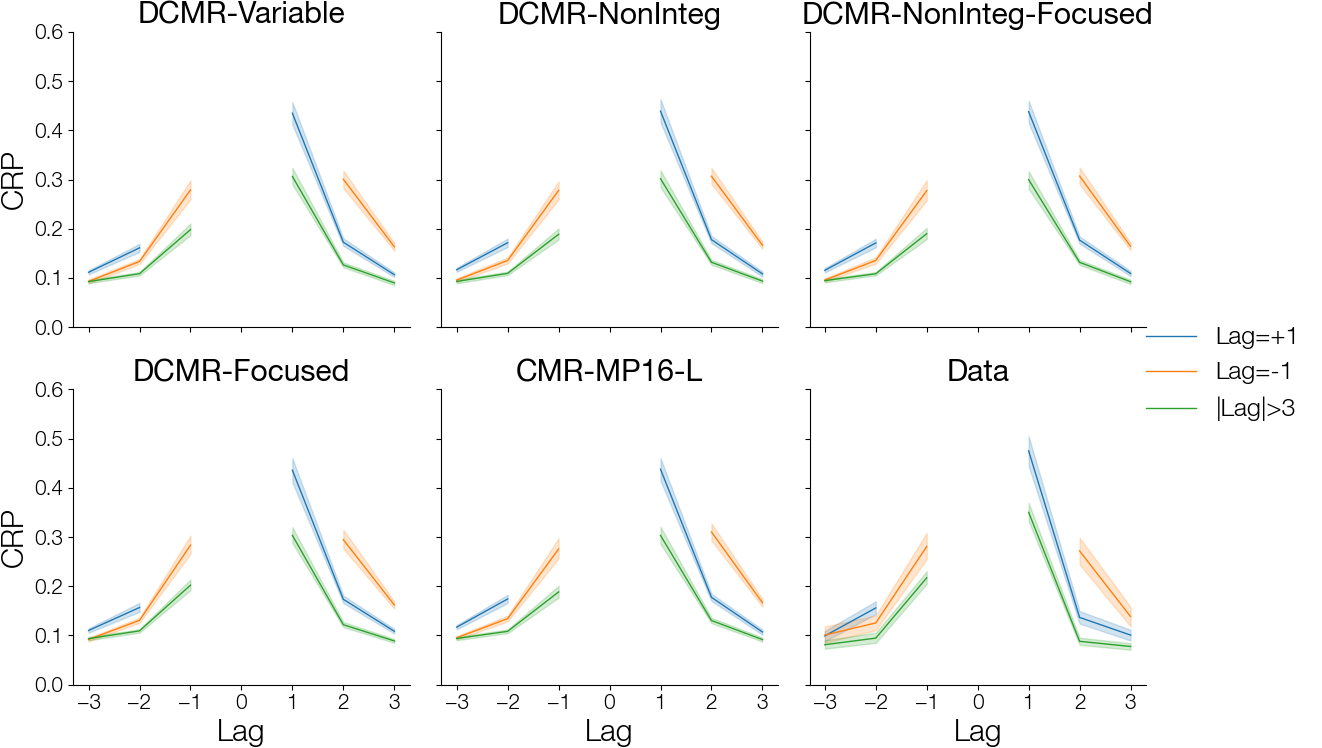

In [42]:
g = fr.plot_lag_crp(
    summed, 
    lag_key='current', 
    hue='Previous', 
    col='source', 
    col_wrap=3, 
    col_order=sources,
    height=4, 
    max_lag=3,    
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [43]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.92118,125,two-sided,1.827842e-17,"[0.1, 0.15]",0.883849,3.079e+14,NaN


In [44]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.998669,125,two-sided,0.000002,"[0.04, 0.09]",0.445317,6970.418,0.99865


### Test for compound cuing in DCMR-Focused

In [45]:
subs = summed.loc['DCMR-Focused']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,20.496422,125,two-sided,8.612247e-42,"[0.12, 0.15]",1.825966,2.599e+38,NaN


In [46]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.098663,125,two-sided,5.874681e-30,"[0.07, 0.09]",1.345096,5.554e+26,NaN


In [47]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.5.0

pandas    : 2.3.2
mindstorm : 0.11.2
seaborn   : 0.13.2
psifr     : 0.10.1
matplotlib: 3.10.5
pingouin  : 0.5.5
cymr      : 0.14.3
numpy     : 2.1.3
scipy     : 1.16.1
dcmr      : 1.0.0a0

